In [1]:
#installs
!pip install fsspec==2023.9.2
!pip install -U datasets
!pip install pandas numpy tensorflow matplotlib torch
!pip install transformers
!pip install tensorflow
!pip install scikit-learn
!pip install librosa
!pip install seaborn


In [8]:
!pip install torchview
!pip install torchviz

In [2]:
#imports for Machine and Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from scipy.special import rel_entr
from sklearn.model_selection import KFold


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


#imports for data science
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#other imports
from datasets import load_dataset
import librosa
import random
import os




/Users/abhinavramalingam/Documents/Uppsala/NCML/Project/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA PROCESSING

In [3]:
SEED = 42
BATCH_SIZE = 32
N_MELS = 128
MAX_LEN = 300

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


In [4]:
ds = load_dataset("AbstractTTS/IEMOCAP", split="train", download_mode="force_redownload")
ds[0]

Generating train split: 100%|██████████| 10039/10039 [00:01<00:00, 5073.65 examples/s]


{'file': 'Ses01F_impro01_F000.wav',
 'audio': {'path': 'Ses01F_impro01_F000.wav',
  'array': array([-0.0050354 , -0.00497437, -0.0038147 , ..., -0.00265503,
         -0.00317383, -0.00418091]),
  'sampling_rate': 16000},
 'frustrated': 0.0062500000931322575,
 'angry': 0.0062500000931322575,
 'sad': 0.0062500000931322575,
 'disgust': 0.0062500000931322575,
 'excited': 0.0062500000931322575,
 'fear': 0.0062500000931322575,
 'neutral': 0.949999988079071,
 'surprise': 0.0062500000931322575,
 'happy': 0.0062500000931322575,
 'EmoAct': 2.3333330154418945,
 'EmoVal': 2.6666669845581055,
 'EmoDom': 2.0,
 'gender': 'Female',
 'transcription': ' Excuse me.',
 'major_emotion': 'neutral',
 'speaking_rate': 5.139999866485596,
 'pitch_mean': 202.79881286621094,
 'pitch_std': 76.12785339355469,
 'rms': 0.00788376946002245,
 'relative_db': -17.938434600830078}

In [5]:
TARGET_EMOTIONS = ['happy', 'sad', 'angry', 'neutral']

def normalize_emotion(e):
    if e == 'excited':
        return 'happy'
    return e if e in TARGET_EMOTIONS else None


In [6]:
#LABEL ENCODING
def process_label(example):
    emotion = normalize_emotion(example['major_emotion'])
    if emotion is None:
        return None
    example['label'] = TARGET_EMOTIONS.index(emotion)
    return example

processed_ds = ds.filter(lambda x: normalize_emotion(x['major_emotion']) is not None)
processed_ds = processed_ds.map(process_label)


Map: 100%|██████████| 6877/6877 [00:03<00:00, 2097.42 examples/s]


In [7]:
# MFCC EXTRACTION
def extract_mfcc(example, n_mfcc=13, max_len=300):
    y = example['audio']['array']
    sr = example['audio']['sampling_rate']
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_len, :]
    example['mfcc'] = mfcc.astype(np.float32)
    return example

processed_ds = processed_ds.map(extract_mfcc)

X = np.array([example['mfcc'] for example in processed_ds])
y = np.array([example['label'] for example in processed_ds])



Map:   0%|          | 0/6877 [00:00<?, ? examples/s]

Map: 100%|██████████| 6877/6877 [03:50<00:00, 29.89 examples/s] 


In [8]:
print(X[0].shape)  # Should be (MAX_LEN, N_MFCC) → e.g., (300, 13)


(300, 13)


In [9]:
#TRAIN_TEST_SPLIT
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

In [10]:
#DATASETS AND DATALOADERS
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MFCCDataset(X_train, y_train)
val_dataset = MFCCDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# BI-LSTM WITH ATTENTION

In [4]:
#DEFINE THE RNN NETWORK
class EmotionRNN(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, num_layers=2, num_classes=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, time, hidden*2)
        out = self.layer_norm(out)
        attn_weights = torch.softmax(self.attn(out), dim=1)  # attention weights
        context = torch.sum(attn_weights * out, dim=1)       # weighted sum (batch, hidden*2)
        context = self.dropout(context)
        return self.fc(context)

In [9]:
from torchview import draw_graph

model = EmotionRNN()
input_sample = torch.zeros(1, 50, 13)
graph = draw_graph(model, input_data=input_sample, graph_name='EmotionRNN', expand_nested=True)
graph.visual_graph.render(format='png')  # Saves a .png


'EmotionRNN.gv.png'

In [ ]:
#TRAINING 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionRNN(input_dim=13, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 50

for epoch in range(max_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optionally save model here
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch 1: Train Loss = 1.1557, Val Loss = 1.1041, Val Accuracy = 49.85%
Epoch 2: Train Loss = 1.0657, Val Loss = 1.0707, Val Accuracy = 52.98%
Epoch 3: Train Loss = 1.0297, Val Loss = 1.0364, Val Accuracy = 53.78%
Epoch 4: Train Loss = 1.0059, Val Loss = 1.0059, Val Accuracy = 54.72%
Epoch 5: Train Loss = 0.9773, Val Loss = 1.0267, Val Accuracy = 53.49%
Epoch 6: Train Loss = 0.9705, Val Loss = 0.9840, Val Accuracy = 55.23%
Epoch 7: Train Loss = 0.9493, Val Loss = 0.9963, Val Accuracy = 55.23%
Epoch 8: Train Loss = 0.9390, Val Loss = 0.9968, Val Accuracy = 55.45%
Epoch 9: Train Loss = 0.9199, Val Loss = 0.9890, Val Accuracy = 55.45%
Epoch 10: Train Loss = 0.9086, Val Loss = 0.9805, Val Accuracy = 56.40%
Epoch 11: Train Loss = 0.9071, Val Loss = 0.9537, Val Accuracy = 57.34%
Epoch 12: Train Loss = 0.8773, Val Loss = 0.9822, Val Accuracy = 57.05%
Epoch 13: Train Loss = 0.8890, Val Loss = 0.9765, Val Accuracy = 57.70%
Epoch 14: Train Loss = 0.8725, Val Loss = 0.9888, Val Accuracy = 56.69%
E

Validation Accuracy: 57.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61       527
           1       0.63      0.58      0.60       250
           2       0.61      0.58      0.60       254
           3       0.48      0.54      0.51       345

    accuracy                           0.58      1376
   macro avg       0.58      0.58      0.58      1376
weighted avg       0.58      0.58      0.58      1376



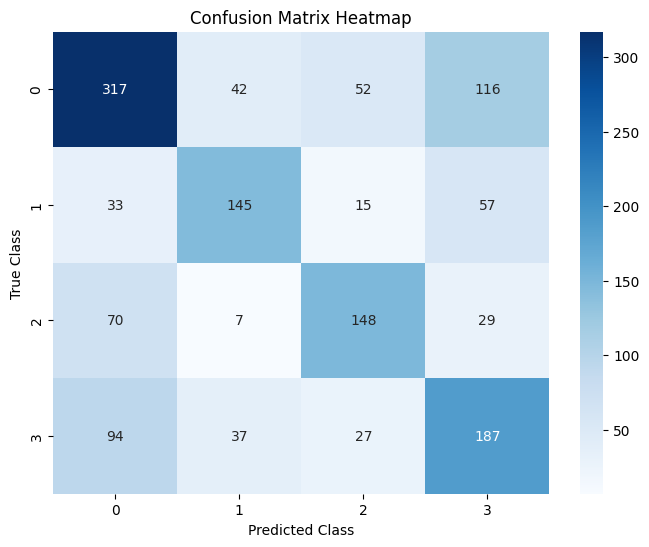

In [ ]:
#EVALUATION
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f'Validation Accuracy: {accuracy:.2f}%')

# Classification report (precision, recall, f1-score)
class_report = classification_report(all_labels, all_preds, target_names=TARGET_EMOTIONS)
print('Classification Report:\n', class_report)

# Confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heatmap')
plt.show()

